In [1]:
import numpy as np
import pandas as pd

import skimage
import skimage.io
from skimage.transform import resize

import matplotlib.pyplot as plt
import seaborn as sns
import time
import cv2

import os
import shutil

from math import sqrt
from numpy import dot
from numpy.linalg import norm

In [2]:
# Число изображений на каждом объекте
N = 1000
# Размер изображения
img_size = 256
# Глубина рекурсии функции бинарного метода Хаара
# Размер вектор-признака равна 2**max_depth - 1 по построению функции
max_depth = 13

# Название объекта изображения
imgs_name_1 = "airplane"
imgs_name_2 = "cars"

# Используемые методы в CBIR системе
numpy2vec_method = "diag"
dec2bin_method = "Harr"
distance_method = "norm_hamming"

In [3]:
# Переименует названия изображений, находящих в файле file_path
def rename_imgs(file_path):
    file_names = os.listdir(file_path)
    i = 0
    for name in file_names:
        src = os.path.join(file_path, name)
        dst = str(i) + ".jpg"
        dst = os.path.join(file_path, dst)
        if not os.path.isfile(dst):
            os.rename(src, dst) 
        i += 1
    
    return "Done"


# Путь к файлам
file_path_1 = "data_\\%s"%(imgs_name_1)
file_path_2 = "data_\\%s"%(imgs_name_2)
# Переименуем все изображения, чтобы полегче обратиться к конкретному изображению
rename_imgs(file_path_1)
rename_imgs(file_path_2)

'Done'

In [4]:
start_time = time.time()

# Импортируем и реобразует картинку в матрицу
def jpg2numpy(file_path):
    img = skimage.io.imread(file_path)
    resized_img = cv2.resize(img, dsize=(img_size, img_size), interpolation=cv2.INTER_CUBIC)
    return np.array(resized_img)


imgs_1, imgs_2 = [], []

# Количесвто изображений на каждый объект (самолет, автомобиль)
N = 1000

for i in range(N):
    # Для первого объекта
    file_path = "data_\\%s\\%d.jpg"%(imgs_name_1, i)
    imgs_1.append(jpg2numpy(file_path))

    # Для второго объекта
    file_path = "data_\\%s\\%d.jpg"%(imgs_name_2, i)
    imgs_2.append(jpg2numpy(file_path))

# массив преобразуем в numpy
imgs_1 = np.array(imgs_1)
imgs_2 = np.array(imgs_2)

# склеим две матрицы в одну
imgs = np.concatenate((imgs_1, imgs_2))

assert imgs_1.shape == (N, img_size, img_size, 3)
assert imgs_2.shape == (N, img_size, img_size, 3)
assert imgs.shape == (2 * N, img_size, img_size, 3)

print("--- %s seconds ---" % (time.time() - start_time))

--- 42.5980019569397 seconds ---


In [5]:
# Перемешивает случайным образом изображений
def shuffle_imgs(matrix):
    return np.random.shuffle(matrix)

A = np.array([1, 2, 3])
print("Shuffle before:", A)
shuffle_imgs(A)
print("\t after:", A)

# Разделяет выборку на поисковую и тестовую часть
def test_search_split(matrix, test_size=0.3, shuffle=True):
    matrix_ = matrix.copy()
    if shuffle:
        shuffle_imgs(matrix_)
    size_of_matrix = len(matrix_)
    threshold = round(size_of_matrix * test_size)
    return matrix_[:threshold], matrix_[threshold:]

A = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
B, C = test_search_split(A, shuffle=False)
np.testing.assert_array_equal(B, np.array([[1, 2, 3]]))
np.testing.assert_array_equal(C, np.array([[4, 5, 6], [7, 8, 9]]))
assert len(B) + len(C) == len(A)

# Сохраняет matrix-изображения в file_path
def save_imgs(file_path, matrix):
    count_of_imgs = len(matrix)
    for i in range(0, count_of_imgs):
        skimage.io.imsave(file_path + "\\%d.jpg"%(i), matrix[i])
    return "Done"


# создание тестового, поискового файла
test_file_path= "data_\\test_dataset"
search_file_path = "data_\\search_dataset"
test_imgs, search_imgs = test_search_split(imgs, shuffle=True)
save_imgs(test_file_path, test_imgs)
save_imgs(search_file_path, search_imgs)

Shuffle before: [1 2 3]
	 after: [3 2 1]


'Done'

In [6]:

imgs_dict = {imgs_name_1:imgs_1, imgs_name_2:imgs_2}
imgs_tuple = []
i = 0
for k, v in imgs_dict.items():
    for words in v:
        imgs_tuple.append((i, k, words))
        i += 1
        
test_imgs_tuple, search_imgs_tuple = test_search_split(imgs_tuple, shuffle=True)

In [7]:
#Преобразование RGB в серый цвет
def RGB2GRAY(img):
    return 0.299 * img[:, :, 0] + 0.587 * img[:, :, 1] + 0.114 * img[:, :, 2]

imgs_gray_tuple = []
for i in range(len(imgs_tuple)):
    imgs_gray_tuple.append((imgs_tuple[i][0], imgs_tuple[i][1], RGB2GRAY(imgs_tuple[i][2])))

In [8]:
#создание tuple для поискового датасета
start_time = time.time()
search_N = len(search_imgs)
search_imgs_gray = []

for i in range(search_N):
    search_imgs_gray.append((search_imgs_tuple[i][0], search_imgs_tuple[i][1], RGB2GRAY(search_imgs_tuple[i][2])))

#создание tuple для тестового датасета
test_N = len(test_imgs)
test_imgs_gray = []
for i in range(test_N):
    test_imgs_gray.append((test_imgs_tuple[i][0], test_imgs_tuple[i][1], RGB2GRAY(test_imgs_tuple[i][2])))
    
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.7958571910858154 seconds ---


In [9]:

# Развертывает матрицу в вектор лесенка
def diag_trans(matrix):
    matrix = np.array(matrix)
    array = []
    r = matrix.shape[0]
    for i in range(-r+1,r):
        array = np.concatenate((array,np.diag(matrix,i)),axis=None)
    return array

# Преобразует матрицу в вектор
def numpy2vec(img_g, method="row"):
    img_g = np.array(img_g)
    if (method == "row"):
        #Развертывание матрицы в вектор постолбцово
        return img_g.reshape(-1)
    elif (method == "col"):
        return img_g.T.reshape(-1)
    elif (method == "diag"):
        #Развертывание матрицы в вектор лесенка
        return diag_trans(img_g)
    return 0

display(np.array([[1,2,3],[4,5,6],[7,8,9]]))
print("row:", numpy2vec([[1,2,3],[4,5,6],[7,8,9]], method="row"), "\n")
print("col:", numpy2vec([[1,2,3],[4,5,6],[7,8,9]], method="col"), "\n")
print("diag:", numpy2vec([[1,2,3],[4,5,6],[7,8,9]], method="diag"), "\n")

array([[1, 2, 3],
       [4, 5, 6],
       [7, 8, 9]])

row: [1 2 3 4 5 6 7 8 9] 

col: [1 4 7 2 5 8 3 6 9] 

diag: [7. 4. 8. 1. 5. 9. 2. 6. 3.] 



In [10]:
start_time = time.time()
# Для поискового датасета
# Количество изображений в поисковом датасете
search_N = len(search_imgs)
# Вектор из кортежей
search_imgs_vec = []
numpy2vec_method = "diag"

for i in range(search_N):
    search_imgs_vec.append((search_imgs_gray[i][0], search_imgs_gray[i][1],
                            numpy2vec(search_imgs_gray[i][2], method=numpy2vec_method)))

# Для тестового датасета
# Количество изображений в тестовом датасете
test_N = len(test_imgs)
# Вектор из кортежей
test_imgs_vec = []

for i in range(test_N):
    test_imgs_vec.append((test_imgs_gray[i][0], test_imgs_gray[i][1],
                          numpy2vec(test_imgs_gray[i][2], method=numpy2vec_method)))

print("--- %s seconds ---" % (time.time() - start_time))

--- 16.58694815635681 seconds ---


In [11]:
# Получает бинарный вектор из обычного вектора методом бинарного вейвлета Хаара
def dec2bin_Harr(vec=[], current_depth=1, max_depth=max_depth):
    size = len(vec)
    if size == 1:
        return [0]
    elif size == 2:
        return [1] if vec[0] > vec[1] else [0]
    elif current_depth > max_depth:
        return []
    else:
        median_index = size // 2
        left_sum, right_sum = sum(vec[:median_index]), sum(vec[median_index:])
        if left_sum > right_sum:
            return dec2bin_Harr(vec[:median_index], current_depth + 1, max_depth) + [1] + dec2bin_Harr(vec[median_index:], current_depth + 1, max_depth)
        else:
            return dec2bin_Harr(vec[:median_index], current_depth + 1, max_depth) + [0] + dec2bin_Harr(vec[median_index:], current_depth + 1, max_depth)
        
a = [1, 2, 3, 4]
assert dec2bin_Harr(a) == [0, 0, 0]

In [12]:
# Получает бинарный вектор из обычного вектора
def dec2bin(vec, method="mean", max_depth=max_depth):
    if (method == "mean"):
        med = np.median(vec)
        binary_array = [int(x >= med) for x in vec]
        return binary_array
    elif (method == "Harr"):
        return dec2bin_Harr(vec, max_depth=max_depth)
    
a = [1, 2, 3, 4, 3, 2, 1]
#sorted_a: 1 1 2 2 3 3 4
assert dec2bin(a, "mean") == [0, 1, 1, 1, 1, 1, 0]

In [13]:
start_time = time.time()
# Для поискового датасета
# Количество изображений в поисковом датасете
search_N = len(search_imgs)
# Вектор из кортежей
search_imgs_bin = []

for i in range(search_N):
    search_imgs_bin.append((search_imgs_vec[i][0], search_imgs_vec[i][1],
                            dec2bin(search_imgs_vec[i][2], method=dec2bin_method)))

# Для тестового датасета
# Количество изображений в тестовом датасете
test_N = len(test_imgs)
# Вектор из кортежей
test_imgs_bin = []

for i in range(test_N):
    test_imgs_bin.append((test_imgs_tuple[i][0], test_imgs_tuple[i][1],
                          dec2bin(test_imgs_vec[i][2], method=dec2bin_method)))

print("--- %s seconds ---" % (time.time() - start_time))

--- 192.10319900512695 seconds ---


In [14]:
# Создаем файл ближайших картинок
search_imgs_bin_number = []
search_imgs_bin_name = []
search_imgs_bin_ = []
for search_img_bin in search_imgs_bin:
    search_imgs_bin_number.append(search_img_bin[0])
    search_imgs_bin_name.append(search_img_bin[1])
    search_imgs_bin_.append(search_img_bin[2])
    
df_search_imgs = pd.DataFrame({"number":search_imgs_bin_number, "class":search_imgs_bin_name, "bin":search_imgs_bin_})
df_search_imgs.to_csv("data_//search_imgs.csv", sep='\t', index=False)

In [15]:
# Вариант 1
# Находит расстояние Хэмминга
def my_hamming_distance(bin1, bin2):
    dist = 0
    for n in range(len(bin1)):
        if bin1[n] != bin2[n]:
            dist += 1
    
    return dist

a = [1, 0, 1, 1, 1, 0, 1]
b = [1, 0, 0, 1, 0, 0, 1]
assert my_hamming_distance(a, b) == 2

# Находит косинусное расстояние
def my_cos_distance(bin1, bin2):
    count_one, sum_bin1, sum_bin2 = 0, 0, 0
    for i in range(len(bin1)):
        count_one += bin1[i] * bin2[i]
        sum_bin1 += bin1[i] #bin1[i]**2
        sum_bin2 += bin2[i] #bin2[i]**2
    return 1 - count_one / (sqrt(sum_bin1) * sqrt(sum_bin2))

a, b = [1, 1, 0, 0], [1, 0, 0, 0] 
assert my_cos_distance(a, b) == 0.29289321881345254

# Находит Евклидовое расстояние
def my_euclid_distance(bin1, bin2):
    dist = 0
    for i in range(len(bin1)):
        dist += (bin1[i] - bin2[i]) ** 2
    return sqrt(dist)

a = [1, 0, 1, 1, 1, 0, 1]
b = [1, 0, 0, 1, 0, 0, 1]
assert my_euclid_distance(a, b) == 1.4142135623730951

# Вариант 2
# Находит расстояние Хэмминга
def hamming_distance(bin1, bin2):
    x = np.array(bin1)
    y = np.array(bin2)  
    return np.sum(x != y)

a = [1, 0, 1, 1, 1, 0, 1]
b = [1, 0, 0, 1, 0, 0, 1]
assert hamming_distance(a, b) == 2
assert hamming_distance(a, b) == my_hamming_distance(a, b)

# Находит косинусное расстояние
def cos_distance(bin1, bin2):
    return 1 - dot(bin1, bin2) / (norm(bin1) * norm(bin2))

a, b = [1, 1, 0, 0], [1, 0, 0, 0] 
assert cos_distance(a, b) == 0.29289321881345254
assert cos_distance(a, b) == my_cos_distance(a, b)

# Находит Евклидовое расстояние
def euclid_distance(bin1, bin2):
    bin1 = np.array(bin1)
    bin2 = np.array(bin2)
    return norm(bin1 - bin2)

a = [1, 0, 1, 1, 1, 0, 1]
b = [1, 0, 0, 1, 0, 0, 1]
assert euclid_distance(a, b) == 1.4142135623730951
assert euclid_distance(a, b) == my_euclid_distance(a, b)

# Нормализует расстояние Хэмминга
def norm_hamming_distance(bin1, bin2):
    return hamming_distance(bin1, bin2) / len(bin1)

# Нормализует расстояние Хэмминга
def my_norm_hamming_distance(bin1, bin2):
    return my_hamming_distance(bin1, bin2) / len(bin1)

# Нормализует расстояние Евклидова
def norm_euclid_distance(bin1, bin2):
    return euclid_distance(bin1, bin2) / len(bin1)

# Находит расстояние
def distance(bin1, bin2, method="hamming"):
    if method == "my_hamming":
        return my_hamming_distance(bin1, bin2)
    elif method == "my_cos":
        return my_cos_distance(bin1, bin2)
    elif method == "my_euclid":
        return my_euclid_distance(bin1, bin2)
    elif method == "hamming":
        return hamming_distance(bin1, bin2)
    elif method == "cos":
        return cos_distance(bin1, bin2)
    elif method == "euclid":
        return euclid_distance(bin1, bin2)
    elif method == "norm_hamming":
        return norm_hamming_distance(bin1, bin2)
    elif method == "norm_euclid":
        return norm_euclid_distance(bin1, bin2)
    elif method == "my_norm_hamming":
        return my_norm_hamming_distance(bin1, bin2)

# Рисует диаграмму по таблице
def show_heatmap(table):
    fig, ax = plt.subplots(figsize=(10, 6))
    ax = sns.heatmap(table, ax=ax)


In [16]:
# Создаем tuple_imgs вектор кортежей
# (номер, класс изображения из поисковой выборки,
# номер, класс изображения из тестовой выборки,
# расстояние между поисковой и тестовой)
start_time = time.time()

# Количесвто изображений в тестовой выборке
test_N = 600
# Количесвто изображений в поисковой выборке
search_N = 1400

hamming_distance_matrix = []
#distance_method="my_norm_hamming"
for i in range(test_N):
    hamming_distance_list = []
    for j in range(search_N):
        hamming_distance_list.append((test_imgs_bin[i][0], test_imgs_bin[i][1],
                                      search_imgs_bin[j][0], search_imgs_bin[j][1],
                                      distance(test_imgs_bin[i][2], search_imgs_bin[j][2], method=distance_method)))
    hamming_distance_matrix.append(hamming_distance_list)
print("--- %s seconds ---" % (time.time() - start_time))

--- 926.9723360538483 seconds ---


In [17]:
pd.DataFrame(hamming_distance_matrix)

,0,1,2,3,4,5,6,7,8,9,...,1390,1391,1392,1393,1394,1395,1396,1397,1398,1399
0,"(132, airplane, 874, airplane, 0.4360883896960...","(132, airplane, 733, airplane, 0.4879746062751...","(132, airplane, 1187, cars, 0.4491515077524112)","(132, airplane, 316, airplane, 0.4762544255890...","(132, airplane, 1723, cars, 0.5047002807959956)","(132, airplane, 1876, cars, 0.4496398486143328)","(132, airplane, 1919, cars, 0.48504456110365035)","(132, airplane, 470, airplane, 0.4690513978757...","(132, airplane, 1213, cars, 0.46624343791966794)","(132, airplane, 738, airplane, 0.4547674276645...",...,"(132, airplane, 1356, cars, 0.42046148211451595)","(132, airplane, 20, airplane, 0.4285191063362227)","(132, airplane, 986, airplane, 0.4509827859846...","(132, airplane, 555, airplane, 0.4136247100476...","(132, airplane, 1091, cars, 0.5670858259064827)","(132, airplane, 1504, cars, 0.47088267610792334)","(132, airplane, 451, airplane, 0.4702722500305...","(132, airplane, 1593, cars, 0.4905383958002686)","(132, airplane, 1693, cars, 0.5061653033817605)","(132, airplane, 692, airplane, 0.4684409717983..."
1,"(528, airplane, 874, airplane, 0.518373824929801)","(528, airplane, 733, airplane, 0.5216701257477...","(528, airplane, 1187, cars, 0.47356855084849225)","(528, airplane, 316, airplane, 0.4916371627395...","(528, airplane, 1723, cars, 0.522280551825174)","(528, airplane, 1876, cars, 0.513856671957026)","(528, airplane, 1919, cars, 0.5153216945427909)","(528, airplane, 470, airplane, 0.4902942253693...","(528, airplane, 1213, cars, 0.44158222439262607)","(528, airplane, 738, airplane, 0.4479306555976...",...,"(528, airplane, 1356, cars, 0.44878525210597)","(528, airplane, 20, airplane, 0.5322915394945672)","(528, airplane, 986, airplane, 0.4346233671102...","(528, airplane, 555, airplane, 0.4365767305579...","(528, airplane, 1091, cars, 0.5385178854840679)","(528, airplane, 1504, cars, 0.41081675009156393)","(528, airplane, 451, airplane, 0.4871200097668...","(528, airplane, 1593, cars, 0.48712000976681724)","(528, airplane, 1693, cars, 0.4675863752899524)","(528, airplane, 692, airplane, 0.4579416432670..."
2,"(1290, cars, 874, airplane, 0.46880722744475645)","(1290, cars, 733, airplane, 0.48748626541325846)","(1290, cars, 1187, cars, 0.4608716884385301)","(1290, cars, 316, airplane, 0.48968379929190575)","(1290, cars, 1723, cars, 0.4927359296789159)","(1290, cars, 1876, cars, 0.4747894030032963)","(1290, cars, 1919, cars, 0.5243560004883409)","(1290, cars, 470, airplane, 0.4309608106458308)","(1290, cars, 1213, cars, 0.44841899645952876)","(1290, cars, 738, airplane, 0.5187400805762422)",...,"(1290, cars, 1356, cars, 0.39775363203516056)","(1290, cars, 20, airplane, 0.48052740813087536)","(1290, cars, 986, airplane, 0.4143572213404957)","(1290, cars, 555, airplane, 0.3887193260896106)","(1290, cars, 1091, cars, 0.537052862898303)","(1290, cars, 1504, cars, 0.4169210108655842)","(1290, cars, 451, airplane, 0.4609937736540105)","(1290, cars, 1593, cars, 0.5767305579294347)","(1290, cars, 1693, cars, 0.495177633988524)","(1290, cars, 692, airplane, 0.4215602490538396)"
3,"(1313, cars, 874, airplane, 0.435233793187645)","(1313, cars, 733, airplane, 0.3979978024661214)","(1313, cars, 1187, cars, 0.4426809913319497)","(1313, cars, 316, airplane, 0.39067268953729706)","(1313, cars, 1723, cars, 0.5065315590282017)","(1313, cars, 1876, cars, 0.4658771822732267)","(1313, cars, 1919, cars, 0.453912831156147)","(1313, cars, 470, airplane, 0.5221584666096936)","(1313, cars, 1213, cars, 0.5361982663899402)","(1313, cars, 738, airplane, 0.48956171407642535)",...,"(1313, cars, 1356, cars, 0.5289952386765963)","(1313, cars, 20, airplane, 0.4291295324136247)","(1313, cars, 986, airplane, 0.4840678793798071)","(1313, cars, 555, airplane, 0.5089732633378098)","(1313, cars, 1091, cars, 0.4475643999511659)","(1313, cars, 1504, cars, 0.48687583933585643)","(1313, cars, 451, airplane, 0.453302405078745)","(1313, cars, 1593, cars, 0.4838237089488463)","(1313, cars

In [18]:
# Отсортирует изображения по расстоянию
def sort_distance(distance_matrix):
    res = []
    n = len(distance_matrix)
    for i in range(n):
        a = sorted(distance_matrix[i], key=lambda x: x[4])
        res.append(a)
    
    return res

start_time = time.time()
# Создаем новый кортеж, отсортированный по расстоянию
sorted_h_distance = sort_distance(hamming_distance_matrix)
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.2650742530822754 seconds ---


In [19]:
# Для красивого результата классификации изображений
# Проверяет на совпадение объекта
def class_by_matrix(info):
    if info[1] != info[3]:
        return 0
    else:
        return 1

# Окрашивает надпись красным цветом поисковое изображение, если объект не совпадает с тестовым
def bad_color(val):
    result = 'black'
    if (not val):
        result = 'red'
    return (result)

# Очишает нижние надписи
def pretty_axis(plt, ax):
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_axis_off()
    plt.tick_params(left=False, bottom=False, top=False, labelbottom=False)

In [20]:
# Рисует изображение из поисковой выборки, стоящим на j-ом месте по расстоянию от i-го тестового изображения
def show_i_nearest_img(i, j, r, k):
    nearest_img_info = sorted_distance[i][j]
    search_index, search_name = nearest_img_info[2], nearest_img_info[3]
    # Рисуем изображение из поисковой выборки
    ax = fig.add_subplot(4, r, k + r + j * r)
    plt.imshow(imgs_gray_tuple[search_index][2], cmap='gray')
    pretty_axis(plt, ax)
    
    # Проверка на совпадение класса
    if (not class_by_matrix(nearest_img_info)):
        plt.title(search_name, color=bad_color(class_by_matrix(nearest_img_info)))
        return 1
    else:
        plt.title(search_name, color=bad_color(class_by_matrix(nearest_img_info)))

    return 0

3


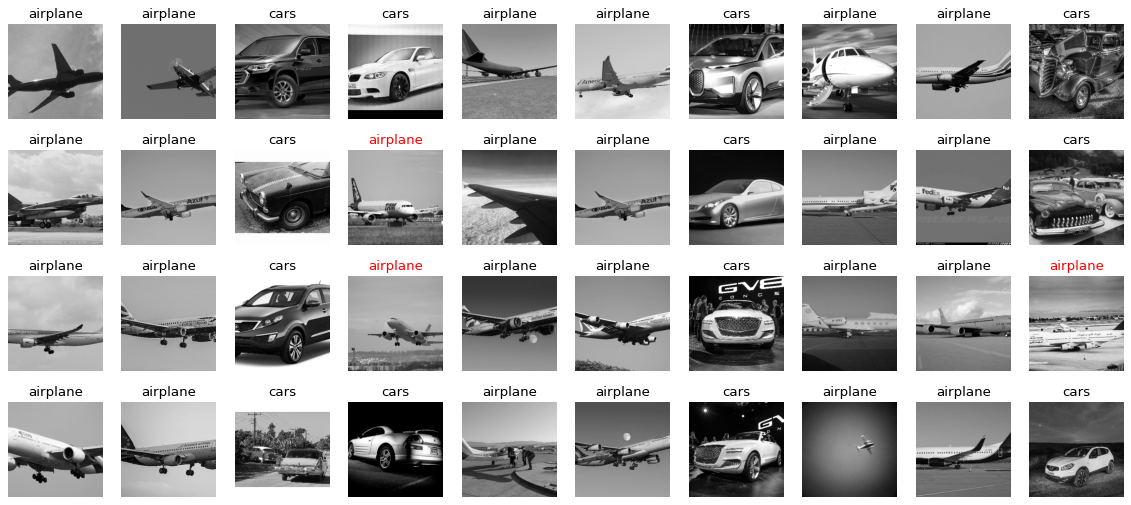

In [21]:
# Нарисуем тестовое изображение и три ближайших изображения из поисковой выборки

fig = plt.figure(figsize=(18, 8), dpi=80)

sorted_distance = sorted_h_distance

k = 1
r = 10
count_false = 0
for i in range(r):
    ax = fig.add_subplot(4, r, k)
    nearest_img_info = sorted_distance[i][0] # так как new_order[0] - это индекс самого изображения к которому ищем ближайшее
    test_index, test_name = nearest_img_info[0], nearest_img_info[1]
    # Рисуем изображение тестовой выборки
    plt.imshow(imgs_gray_tuple[test_index][2], cmap='gray')
    pretty_axis(plt, ax)
    plt.title(test_name)
    
    count_false += show_i_nearest_img(i, 0, r, k)
    count_false += show_i_nearest_img(i, 1, r, k)
    count_false += show_i_nearest_img(i, 2, r, k)

    k = k + 1

print(count_false)

In [22]:
# Найдем accuracy для всех ближайших изображений
sorted_distance = sorted_h_distance

r = 600
count_false = 0
for i in range(r):
    nearest_img_info = sorted_distance[i][0] # так как new_order[0] - это индекс самого изображения к которому ищем ближайшее
    test_index, search_index = nearest_img_info[0], nearest_img_info[2]
    test_name, search_name = nearest_img_info[1], nearest_img_info[3]
    
    # проверка на совпадение классов
    if (not class_by_matrix(nearest_img_info)):
        count_false += 1

print("accuracy:", 1 - count_false / r)

accuracy: 0.7533333333333333


In [23]:
# Cоздадим файл ближайших изображений
df_sorted_dist_3 = pd.DataFrame(sorted_distance).loc[:, 0:3]
df_sorted_dist_3.to_csv("data_//sorted_dist.csv", sep='\t', index=False)

In [24]:
df_sorted_dist_3

,0,1,2,3
0,"(132, airplane, 858, airplane, 0.3606397265291...","(132, airplane, 3, airplane, 0.3721157367842754)","(132, airplane, 421, airplane, 0.375900378464168)","(132, airplane, 618, airplane, 0.3815162983762..."
1,"(528, airplane, 307, airplane, 0.3581980222195...","(528, airplane, 291, airplane, 0.3617384934684...","(528, airplane, 282, airplane, 0.3760224636796...","(528, airplane, 16, airplane, 0.3818825540227079)"
2,"(1290, cars, 1715, cars, 0.321084116713466)","(1290, cars, 1489, cars, 0.32963008179709435)","(1290, cars, 1732, cars, 0.3518495910145281)","(1290, cars, 1547, cars, 0.3536808692467342)"
3,"(1313, cars, 217, airplane, 0.35844219265047)","(1313, cars, 255, airplane, 0.362348919545843)","(1313, cars, 1119, cars, 0.3682090098889024)","(1313, cars, 629, airplane, 0.37687706018801126)"
4,"(39, airplane, 657, airplane, 0.3243804175314369)","(39, airplane, 666, airplane, 0.32731046270296...","(39, airplane, 139, airplane, 0.33915272860456...","(39, airplane, 109, airplane, 0.3393968990355268)"
...,...,...,...,...
595,"(1674, cars, 1130, cars, 0.3580759370040288)","(1674, cars, 1125, cars, 0.36845318031986324)","(1674, cars, 1206, cars, 0.37345867415455986)","(1674, cars, 1783, cars, 0.3751678671712856)"
596,"(650, airplane, 104, airplane, 0.2757905017702...","(650, airplane, 935, airplane, 0.2828714442680...","(650, airplane, 801, airplane, 0.2890977902575...","(650, airplane, 77, airplane, 0.29068489805884..."
597,"(93, airplane, 554, airplane, 0.3096081064583079)","(93, airplane, 713, airplane, 0.31620070809424...","(93, airplane, 340, airplane, 0.3628372604077646)","(93, airplane, 3, airplane, 0.37077279941399094)"
598,"(333, airplane, 345, airplane, 0.3829813209620...","(333, airplane, 968, airplane, 0.3878647295812...","(333, airplane, 511, airplane, 0.3965327798803...","(333, airplane, 122, airplane, 0.4000732511292..."


In [25]:
graph = []
n = 600
m = 1400
for i in range(n):
    one_line = []
    for j in range(m):
        one_line.append(class_by_matrix(sorted_distance[i][j]))
    graph.append(one_line)

In [26]:
pd.DataFrame(sorted_distance)

,0,1,2,3,4,5,6,7,8,9,...,1390,1391,1392,1393,1394,1395,1396,1397,1398,1399
0,"(132, airplane, 858, airplane, 0.3606397265291...","(132, airplane, 3, airplane, 0.3721157367842754)","(132, airplane, 421, airplane, 0.375900378464168)","(132, airplane, 618, airplane, 0.3815162983762...","(132, airplane, 933, airplane, 0.3848125991942...","(132, airplane, 554, airplane, 0.384934684409718)","(132, airplane, 756, airplane, 0.3854230252716...","(132, airplane, 30, airplane, 0.3865217922109633)","(132, airplane, 713, airplane, 0.3866438774264...","(132, airplane, 91, airplane, 0.388841411305091)",...,"(132, airplane, 911, airplane, 0.5818581369796...","(132, airplane, 1661, cars, 0.5819802221950922)","(132, airplane, 1460, cars, 0.5849102673666219)","(132, airplane, 85, airplane, 0.5872298864607496)","(132, airplane, 1155, cars, 0.5889390794774753)","(132, airplane, 175, airplane, 0.591869124649005)","(132, airplane, 828, airplane, 0.5921132950799...","(132, airplane, 719, airplane, 0.5939445733121...","(132, airplane, 1246, cars, 0.5951654254669759)","(132, airplane, 1838, cars, 0.5985838115004273)"
1,"(528, airplane, 307, airplane, 0.3581980222195...","(528, airplane, 291, airplane, 0.3617384934684...","(528, airplane, 282, airplane, 0.3760224636796...","(528, airplane, 16, airplane, 0.3818825540227079)","(528, airplane, 1847, cars, 0.38334757660847274)","(528, airplane, 420, airplane, 0.3840800879013...","(528, airplane, 1799, cars, 0.384934684409718)","(528, airplane, 1969, cars, 0.3851788548406788)","(528, airplane, 1948, cars, 0.38615553656452206)","(528, airplane, 990, airplane, 0.3865217922109...",...,"(528, airplane, 267, airplane, 0.5864973751678...","(528, airplane, 548, airplane, 0.5877182273226...","(528, airplane, 57, airplane, 0.5883286534000732)","(528, airplane, 229, airplane, 0.5896715907703...","(528, airplane, 610, airplane, 0.5901599316322...","(528, airplane, 1276, cars, 0.5977292149920644)","(528, airplane, 1169, cars, 0.5978513002075448)","(528, airplane, 911, airplane, 0.5991942375778...","(528, airplane, 85, airplane, 0.6101819069710658)","(528, airplane, 233, airplane, 0.6122573556342..."
2,"(1290, cars, 1715, cars, 0.321084116713466)","(1290, cars, 1489, cars, 0.32963008179709435)","(1290, cars, 1732, cars, 0.3518495910145281)","(1290, cars, 1547, cars, 0.3536808692467342)","(1290, cars, 1939, cars, 0.35465755097057744)","(1290, cars, 1017, cars, 0.3561225735563423)","(1290, cars, 1800, cars, 0.35990721523623487)","(1290, cars, 1567, cars, 0.3610059821755585)","(1290, cars, 1973, cars, 0.36454645342449027)","(1290, cars, 1731, cars, 0.36674398730313756)",...,"(1290, cars, 233, airplane, 0.6071297765840556)","(1290, cars, 1641, cars, 0.6082285435233793)","(1290, cars, 538, airplane, 0.6082285435233793)","(1290, cars, 184, airplane, 0.6109144182639482)","(1290, cars, 727, airplane, 0.611769014772311)","(1290, cars, 301, airplane, 0.6121352704187523)","(1290, cars, 236, airplane, 0.6127456964961543)","(1290, cars, 85, airplane, 0.6148211451593212)","(1290, cars, 911, airplane, 0.620192894640459)","(1290, cars, 1147, cars, 0.6330118422659016)"
3,"(1313, cars, 217, airplane, 0.35844219265047)","(1313, cars, 255, airplane, 0.362348919545843)","(1313, cars, 1119, cars, 0.3682090098889024)","(1313, cars, 629, airplane, 0.37687706018801126)","(1313, cars, 957, airplane, 0.3800512757905018)","(1313, cars, 500, airplane, 0.38163838359174707)","(1313, cars, 1380, cars, 0.3876205591502869)","(1313, cars, 675, airplane, 0.38823098522768895)","(1313, cars, 871, airplane, 0.3892076669515322)","(1313, cars, 1971, cars, 0.389451837382493)",...,"(1313, cars, 599, airplane, 0.5941887437431327)","(1313, cars, 380, airplane, 0.5943108289586131)","(1313, cars, 161, airplane, 0.5967525332682212)","(1313, cars, 92, airplane, 0.5968746184837016)","(1313, cars, 499, airplane, 0.5968746184837016)","(1313, cars, 594, airplane, 0.5972408741301428)","(1313, cars, 346, airplane, 0.5985838115004273)","(1313, cars, 38, airplane, 0.6131119521

In [27]:
start_time = time.time()

n = search_N
y = []

dist_mean = pd.DataFrame(graph).mean()

for i in range(1, n):
    y.append(dist_mean[:i].mean())
y = 1 - np.array(y)
print(time.time() - start_time)

0.3009343147277832


In [28]:
n = search_N
x = [i for i in range(1, n)]


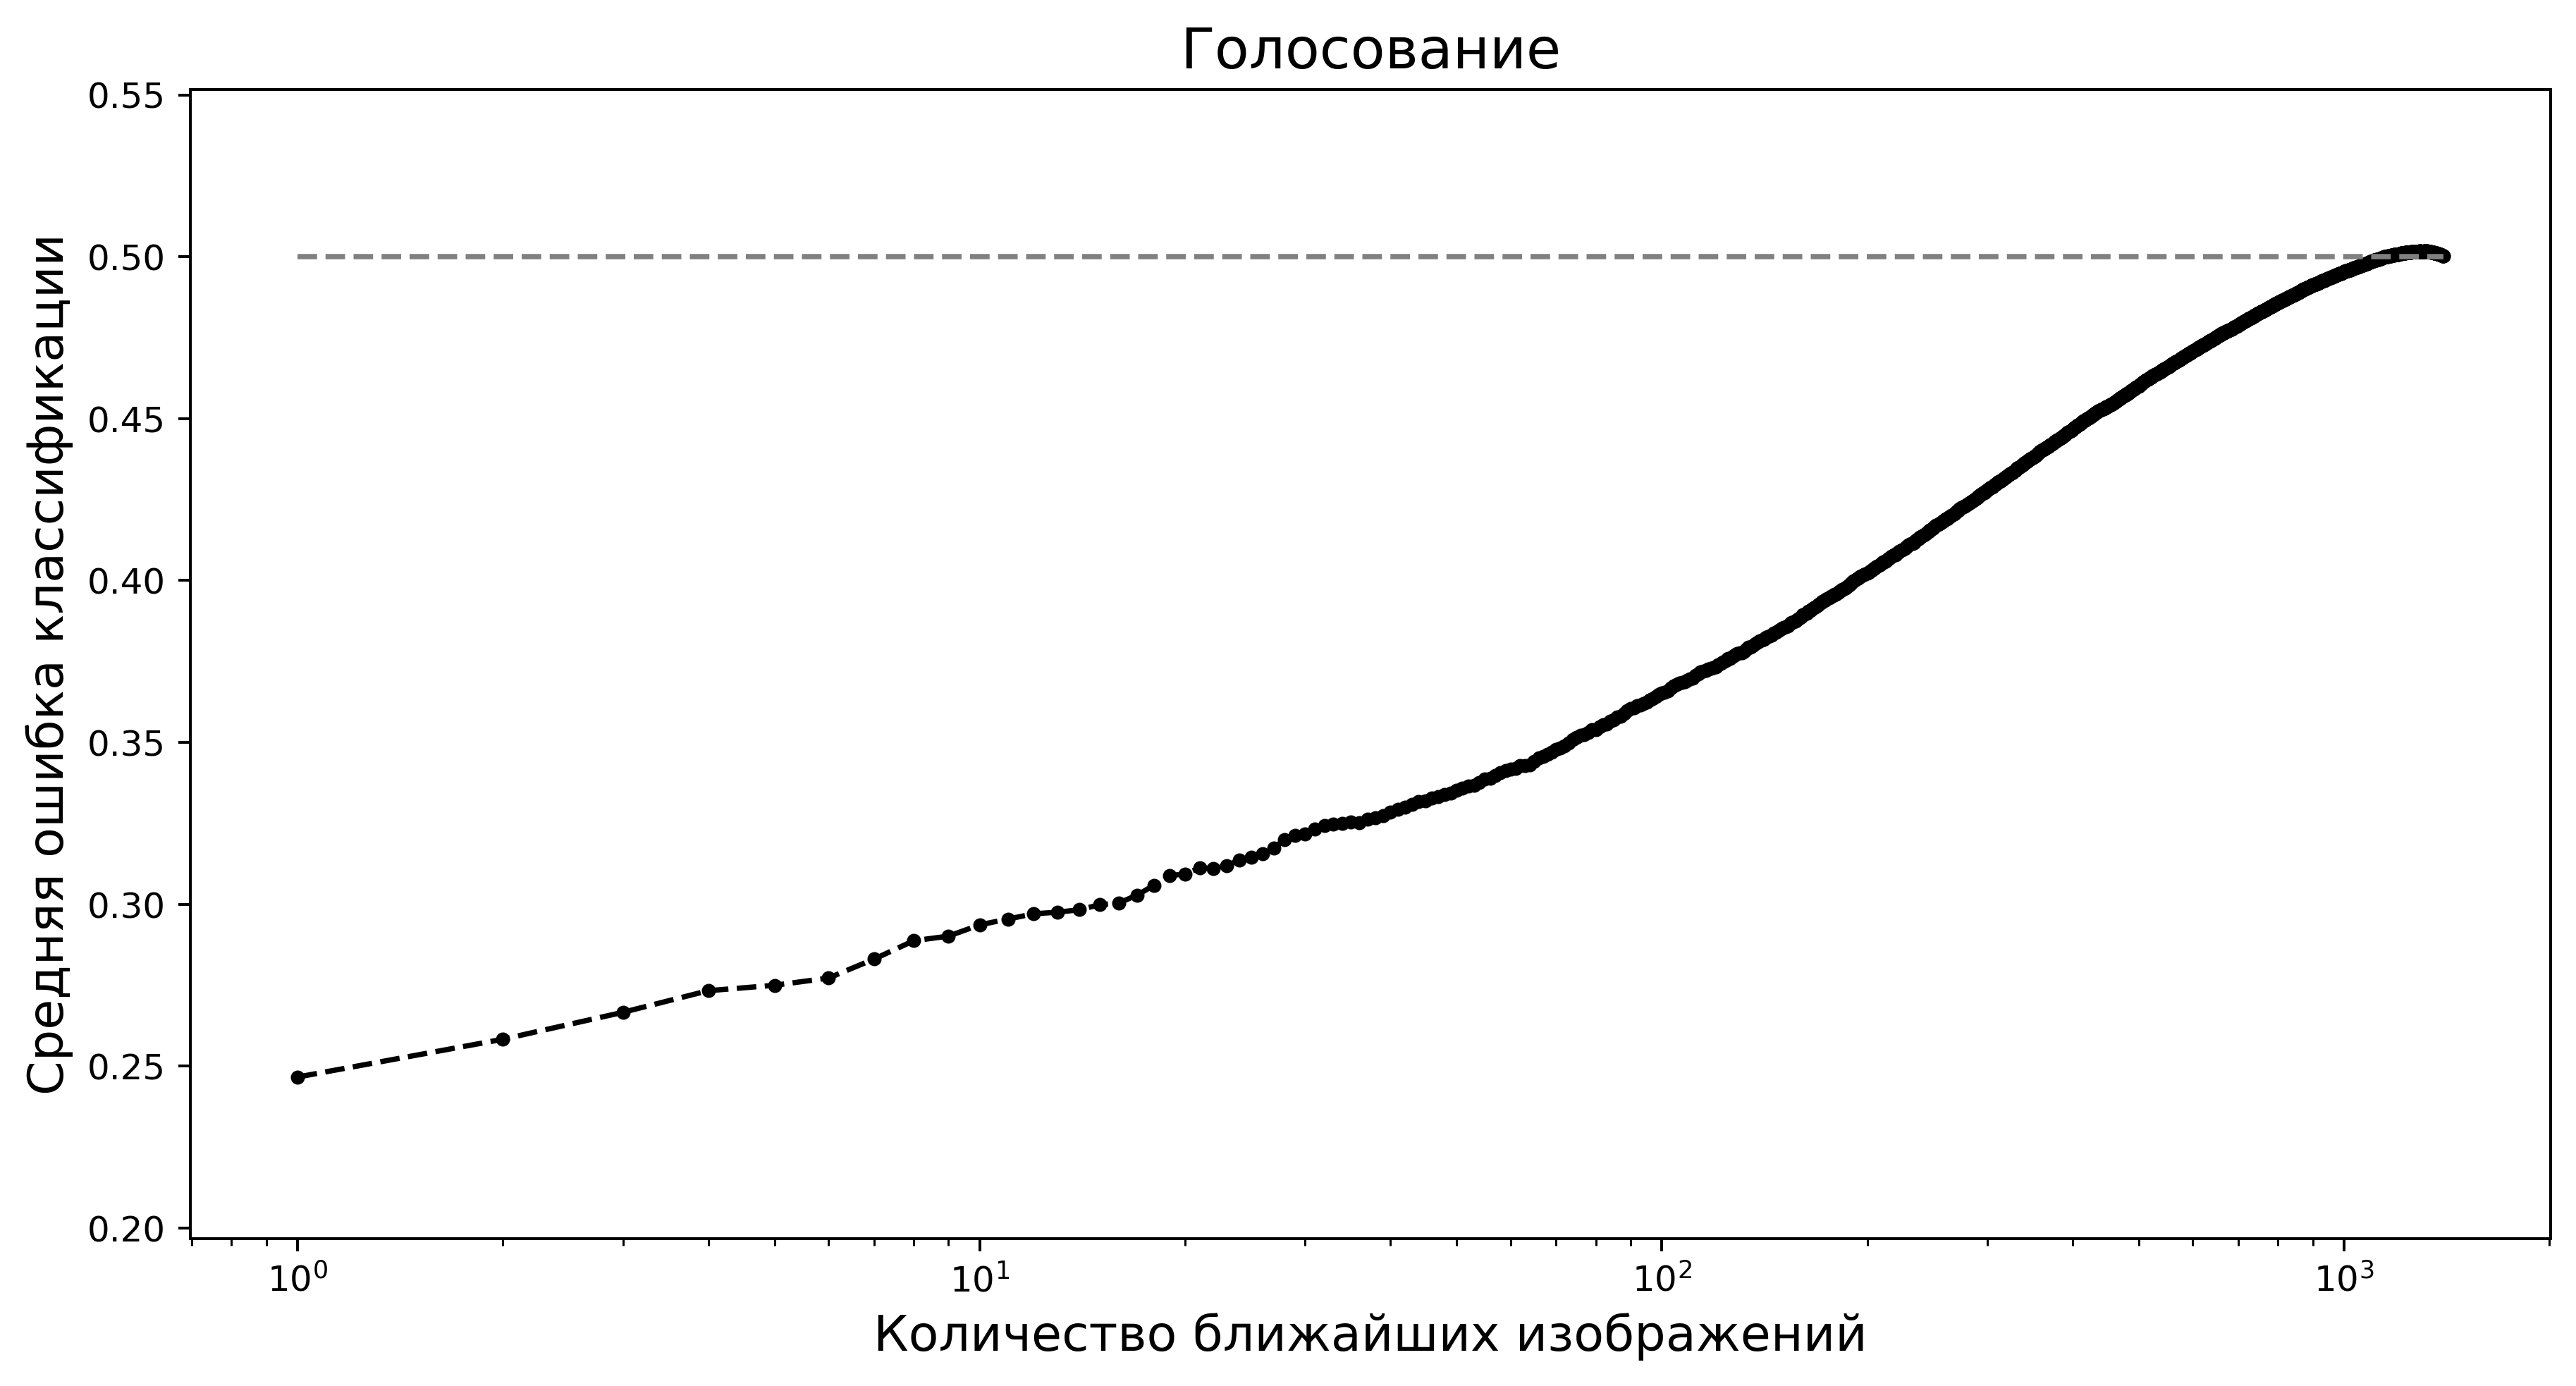

In [29]:
fig, ax = plt.subplots(figsize=(12, 6), dpi=360)
ax.set_xscale('log')
plt.plot(x, y, linestyle="--", marker=".", color="black")
plt.hlines(0.5, np.min(x), np.max(x), linestyle="--", color='gray')
plt.ylim([y.min() - 0.05, y.max() + 0.05])
#plt.xlim([0, 100])
plt.xlabel('Количество ближайших изображений', fontsize=14)
plt.ylabel('Средняя ошибка классификации', fontsize=14)
plt.title('Голосование', fontsize=16)
plt.savefig('Voting_1_Harr.png', bbox_inches='tight')
plt.show()

In [30]:
optimal_N = np.argmin(y) + 1
print("оптимальный размер ближайших изображений:", optimal_N,
      "\nоценка ошибки (accuracy):", y[optimal_N])

оптимальный размер ближайших изображений: 1 
оценка ошибки (accuracy): 0.2583333333333333


In [37]:
# Преобразуем RGB картинку в серый цвет
# Создается вектор из кортежей (номер изображения, название объекта, бинарный вектор-признак изображения)
# Для поискового датасета
search_N = len(search_imgs)
search_imgs_gray = []

for i in range(search_N):
    search_imgs_gray.append((search_imgs_tuple[i][0], search_imgs_tuple[i][1], RGB2GRAY(search_imgs_tuple[i][2])))

# тестового датасета
test_N = len(test_imgs)
test_imgs_gray = []
for i in range(test_N):
    test_imgs_gray.append((test_imgs_tuple[i][0], test_imgs_tuple[i][1], RGB2GRAY(test_imgs_tuple[i][2])))

# Преобразуем матрицу в вектор
# Для поискового датасета
search_N = len(search_imgs)
search_imgs_vec = []
numpy2vec_method = "diag"

for i in range(search_N):
    search_imgs_vec.append((search_imgs_gray[i][0], search_imgs_gray[i][1],
                            numpy2vec(search_imgs_gray[i][2], method=numpy2vec_method)))

# Для тестового датасета
test_N = len(test_imgs)
test_imgs_vec = []

for i in range(test_N):
    test_imgs_vec.append((test_imgs_gray[i][0], test_imgs_gray[i][1],
                          numpy2vec(test_imgs_gray[i][2], method=numpy2vec_method)))

def collect_data_for_graph(max_depth, k=3):
    # Преобразуем десятичный вектор в двоичный
    # Для поискового датасета
    start_time = time.time()
    search_N = len(search_imgs)
    search_imgs_bin = []
    # Зафиксируем k=3 для построения графика средней ошибки классификации от размерности бинарного вектора
    # k - количество ближайших изображений
    k = 3

    for i in range(search_N):
        search_imgs_bin.append((search_imgs_vec[i][0], search_imgs_vec[i][1],
                                dec2bin(search_imgs_vec[i][2], method=dec2bin_method, max_depth=max_depth)))

    # Для тестового датасета
    test_N = len(test_imgs)
    test_imgs_bin = []

    for i in range(test_N):
        test_imgs_bin.append((test_imgs_tuple[i][0], test_imgs_tuple[i][1],
                              dec2bin(test_imgs_vec[i][2], method=dec2bin_method, max_depth=max_depth)))

    # Находим расстояния по Хэмминге
    # номер, класс т, номер, класс п, расстояние
    # Создаем tuple_imgs вектор из кортежей (номер изображения, название объекта, бинарный вектор-признак изображения)
    hamming_distance_matrix = []
    #distance_method="my_norm_hamming"
    for i in range(test_N):
        hamming_distance_list = []
        for j in range(search_N):
            hamming_distance_list.append((test_imgs_bin[i][0], test_imgs_bin[i][1],
                                          search_imgs_bin[j][0], search_imgs_bin[j][1],
                                          distance(test_imgs_bin[i][2], search_imgs_bin[j][2], method=distance_method)))
        hamming_distance_matrix.append(hamming_distance_list)
    
    sorted_h_distance = sort_distance(hamming_distance_matrix)

    graph = []
    n = 600
    m = 1400
    for i in range(n):
        one_line = []
        for j in range(m):
            one_line.append(class_by_matrix(sorted_h_distance[i][j]))
        graph.append(one_line)
    
    dist_mean = pd.DataFrame(graph).mean()
    print("--- %s seconds ---" % (time.time() - start_time))
    return dist_mean[:k].mean()

In [32]:
max_depthes = [1, 3, 5, 7, 9, 11, 13, 15, 17]
y = []
for max_depth in max_depthes:
    y.append(collect_data_for_graph(max_depth))


--- 16.396586179733276 seconds ---
--- 37.92217254638672 seconds ---
--- 61.9651894569397 seconds ---
--- 94.09040546417236 seconds ---
--- 161.05932688713074 seconds ---
--- 365.4281017780304 seconds ---
--- 1115.4197225570679 seconds ---
--- 7734.752373218536 seconds ---
--- 7728.793496131897 seconds ---


In [41]:
y = 1 - np.array(y)
n = len(y)
x = [i for i in max_depthes][:len(y)]
y

array([0.50166667, 0.46111111, 0.42666667, 0.38388889, 0.345     ,
       0.30222222, 0.26333333, 0.29166667, 0.29166667])

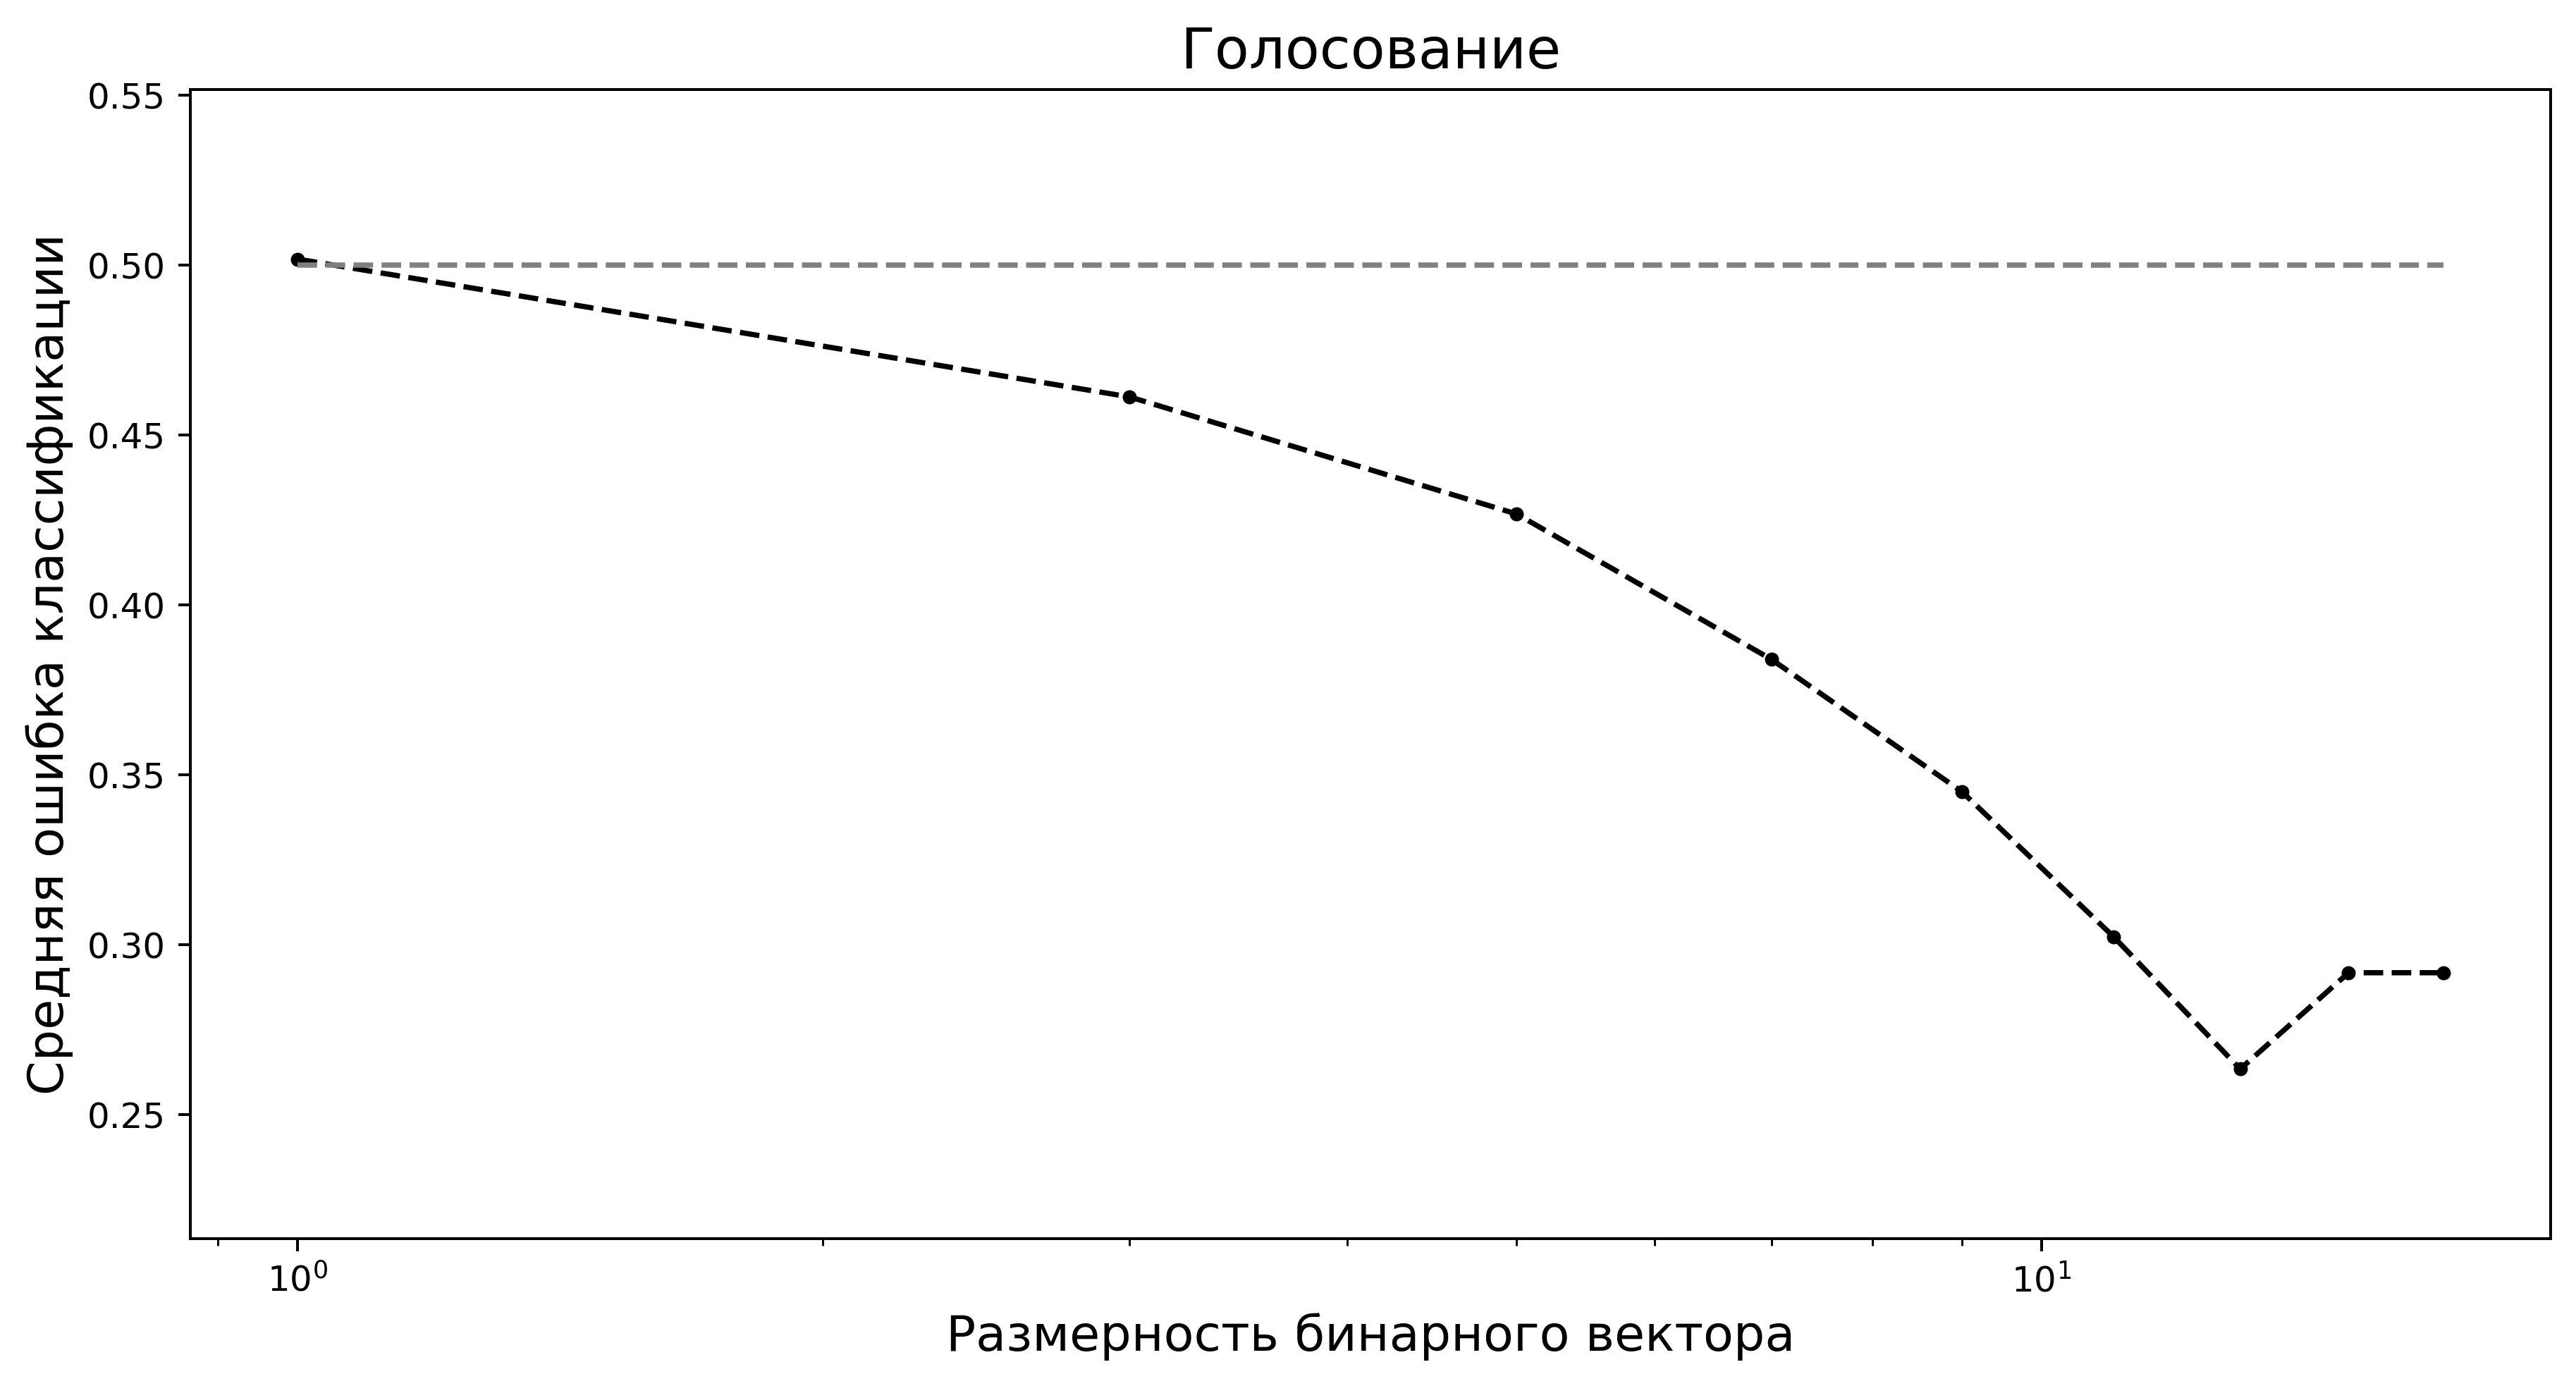

In [42]:
fig, ax = plt.subplots(figsize=(12, 6), dpi=360)
ax.set_xscale('log')
plt.plot(x, y, linestyle="--", marker=".", color="black")
plt.hlines(0.5, np.min(x), np.max(x), linestyle="--", color='gray')
plt.ylim([y.min() - 0.05, y.max() + 0.05])
#plt.xlim([0, 100])
plt.xlabel('Размерность бинарного вектора', fontsize=14)
plt.ylabel('Средняя ошибка классификации', fontsize=14)
plt.title('Голосование', fontsize=16)
plt.savefig('Voting_2_Harr.png', bbox_inches='tight')
plt.show()

In [35]:
optimal_N = np.argmin(y)
print("подходящий размер ближайших изображений:", max_depthes[optimal_N],
      "\nоценка ошибки (accuracy):", y[optimal_N])

подходящий размер ближайших изображений: 13 
оценка ошибки (accuracy): 0.2666666666666666


In [43]:
collect_data_for_graph(int(x[optimal_N]), k=1)

--- 1142.4836158752441 seconds ---


0.7333333333333334

In [39]:
# y = [0.50388889, 0.47777778, 0.435, 0.38888889, 0.34222222, 0.30222222, 0.28944444, 0.31833333, 0.31833333]
# y = [0.50166667, 0.46111111, 0.42666667, 0.38388889, 0.345, 0.30222222, 0.26333333, 0.29166667, 0.29166667]